In [1]:
import json
import os
import pickle
from abc import abstractmethod

import librosa as librosa
import pandas as pd
import torch
from enum import Enum
import typing as tp
from dataclasses import dataclass
import numpy as np
import torchaudio
from sklearn.metrics import accuracy_score
import sklearn
ROOT = ""

In [2]:

class Genre(Enum):
    """
    This enum class is optional and defined for your convinience, you are not required to use it.
    Please use the int labels this enum defines for the corresponding genras in your predictions.
    """
    CLASSICAL: int = 0
    HEAVY_ROCK: int = 1
    REGGAE: int = 2


@dataclass
class TrainingParameters:
    """
    This dataclass defines a training configuration.
    feel free to add/change it as you see fit, do NOT remove the following fields as we will use
    them in test time.
    If you add additional values to your training configuration please add them in here with
    default values (so run won't break when we test this).
    """
    batch_size: int = 32
    num_epochs: int = 50
    train_json_path: str = "jsons/train.json"  # you should use this file path to load your train data
    test_json_path: str = "jsons/test.json"  # you should use this file path to load your test data
    # other training hyper parameters


@dataclass
class OptimizationParameters:
    """
    This dataclass defines optimization related hyper-parameters to be passed to the model.
    feel free to add/change it as you see fit.
    """
    learning_rate: float = 0.001


class MusicClassifier:
    """
    You should Implement your classifier object here
    """

    def __init__(self, opt_params: OptimizationParameters, **kwargs):
        """
        This defines the classifier object.
        - You should defiend your weights and biases as class components here.
        - You could use kwargs (dictionary) for any other variables you wish to pass in here.
        - You should use `opt_params` for your optimization and you are welcome to experiment
        """
        self.weights = torch.zeros(size=(kwargs["num_features"], len(Genre)), dtype=torch.float32)
        self.biases = torch.zeros(size=(1, len(Genre)), dtype=torch.float32)
        self.opt_params = opt_params

    def exctract_feats(self, wavs: torch.Tensor):
        """
        this function extract features from a given audio.
        we will not be observing this method.
        """
        ## features extraction
        features_list = []
        batch_size = wavs.size()[0]
        data = wavs.numpy()
        # first family - crossing rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=data)
        avg_zero_crossing_rate = np.mean(zero_crossing_rate, axis=(1, 2))
        std_zero_crossing_rate = np.std(zero_crossing_rate, axis=(1, 2))
        features_list.append(torch.tensor(avg_zero_crossing_rate, dtype=torch.float32).view(batch_size, 1))
        features_list.append(torch.tensor(std_zero_crossing_rate, dtype=torch.float32).view(batch_size, 1))
        # print("zero crossing rate: ", zero_crossing_rate.shape, avg_zero_crossing_rate.shape,
        #       std_zero_crossing_rate.shape)

        # second family - spectral
        spectral_centroid = librosa.feature.spectral_centroid(y=data)
        avg_spectral_centroid = np.mean(spectral_centroid, axis=(1, 2))
        std_spectral_centroid = np.std(spectral_centroid, axis=(1, 2))
        # print("spectral centroid: ", spectral_centroid.shape, avg_spectral_centroid.shape,
        #       std_spectral_centroid.shape)
        features_list.append(torch.tensor(avg_spectral_centroid, dtype=torch.float32).view(batch_size, 1))
        features_list.append(torch.tensor(std_spectral_centroid, dtype=torch.float32).view(batch_size, 1))

        # third family - spectral contrast
        # spectral_contrast = librosa.feature.spectral_contrast(y=data)
        # avg_spectral_contrast = np.mean(spectral_contrast, axis=(1, 2))
        # std_spectral_contrast = np.std(spectral_contrast, axis=(1, 2))
        # # print("spectral contrast: ", spectral_contrast.shape, avg_spectral_contrast.shape,
        # #       std_spectral_contrast.shape)
        # features_list.append(torch.tensor(avg_spectral_contrast, dtype=torch.float32).view(batch_size, 1))
        # features_list.append(torch.tensor(std_spectral_contrast, dtype=torch.float32).view(batch_size, 1))

        # forth family - log RMS
        log_rms = librosa.feature.rms(y=librosa.amplitude_to_db(abs(data)))
        avg_log_rms = np.mean(log_rms, axis=(1, 2))
        std_log_rms = np.std(log_rms, axis=(1, 2))
        # print("log RMS: ", log_rms.shape, avg_log_rms.shape, std_log_rms.shape)
        features_list.append(torch.tensor(avg_log_rms, dtype=torch.float32).view(batch_size, 1))
        features_list.append(torch.tensor(std_log_rms, dtype=torch.float32).view(batch_size, 1))

        # # fifth family MFCC features
        mfcc = librosa.feature.mfcc(y=data, n_mfcc=13)
        # Padding first and second deltas
        delta_mfcc = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)
        zero_order_mfcc = np.mean(mfcc, axis=2)
        first_order_mfcc = np.mean(delta_mfcc, axis=2)
        second_order_mfcc = np.mean(delta2_mfcc, axis=2)

        # print("MFCC: ", mfcc.shape, zero_order_mfcc.shape, first_order_mfcc.shape, second_order_mfcc.shape)
        features_list.append(torch.tensor(zero_order_mfcc, dtype=torch.float32).view(batch_size, 13))
        features_list.append(torch.tensor(first_order_mfcc, dtype=torch.float32).view(batch_size, 13))
        features_list.append(torch.tensor(second_order_mfcc, dtype=torch.float32).view(batch_size, 13))

        # sixth family - chroma
        # chroma = librosa.feature.chroma_stft(y=data)
        # avg_chroma = np.mean(chroma, axis=(1, 2))
        # std_chroma = np.std(chroma, axis=(1, 2))
        # # print("chroma: ", chroma.shape, avg_chroma.shape, std_chroma.shape)
        # features_list.append(torch.tensor(avg_chroma, dtype=torch.float32).view(batch_size, 1))
        # features_list.append(torch.tensor(std_chroma, dtype=torch.float32).view(batch_size, 1))

        # seventh family - tonnetz
        # tonnetz = librosa.feature.tonnetz(y=data)
        # avg_tonnetz = np.mean(tonnetz, axis=(1, 2))
        # std_tonnetz = np.std(tonnetz, axis=(1, 2))
        # # print("tonnetz: ", tonnetz.shape, avg_tonnetz.shape, std_tonnetz.shape)
        # features_list.append(torch.tensor(avg_tonnetz, dtype=torch.float32).view(batch_size, 1))
        # features_list.append(torch.tensor(std_tonnetz, dtype=torch.float32).view(batch_size, 1))

        # eigth - spectral flatness, rolloff, bandwidth
        spectral_flatness = librosa.feature.spectral_flatness(y=data)
        avg_spectral_flatness = np.mean(spectral_flatness, axis=(1, 2))
        std_spectral_flatness = np.std(spectral_flatness, axis=(1, 2))
        # print("spectral flatness: ", spectral_flatness.shape, avg_spectral_flatness.shape,
        #       std_spectral_flatness.shape)
        features_list.append(torch.tensor(avg_spectral_flatness, dtype=torch.float32).view(batch_size, 1))
        features_list.append(torch.tensor(std_spectral_flatness, dtype=torch.float32).view(batch_size, 1))

        spectral_rolloff = librosa.feature.spectral_rolloff(y=data)
        avg_spectral_rolloff = np.mean(spectral_rolloff, axis=(1, 2))
        std_spectral_rolloff = np.std(spectral_rolloff, axis=(1, 2))
        # print("spectral rolloff: ", spectral_rolloff.shape, avg_spectral_rolloff.shape,
        #       std_spectral_rolloff.shape)
        features_list.append(torch.tensor(avg_spectral_rolloff, dtype=torch.float32).view(batch_size, 1))
        features_list.append(torch.tensor(std_spectral_rolloff, dtype=torch.float32).view(batch_size, 1))

        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=data)
        avg_spectral_bandwidth = np.mean(spectral_bandwidth, axis=(1, 2))
        std_spectral_bandwidth = np.std(spectral_bandwidth, axis=(1, 2))
        # print("spectral bandwidth: ", spectral_bandwidth.shape, avg_spectral_bandwidth.shape,
        #       std_spectral_bandwidth.shape)
        features_list.append(torch.tensor(avg_spectral_bandwidth, dtype=torch.float32).view(batch_size, 1))
        features_list.append(torch.tensor(std_spectral_bandwidth, dtype=torch.float32).view(batch_size, 1))


        features = torch.cat(features_list, dim=1)

        return features

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + torch.exp(-z))

    @staticmethod
    def softmax(z):
        exps = torch.exp(z-torch.max(z))
        return  exps / torch.sum(exps, dim=1, keepdim=True)

    def forward(self, feats: torch.Tensor) -> tp.Any:
        """
        this function performs a forward pass throuh the model, outputting scores for every class.
        feats: batch of extracted faetures
        """
        x = torch.mm(feats, self.weights) + self.biases
        transformed_x = x - torch.max(x, dim=1, keepdim=True)[0]
        return torch.softmax(transformed_x, dim=1)

    def backward(self, feats: torch.Tensor, output_scores: torch.Tensor, labels: torch.Tensor):
        """
        this function should perform a backward pass through the model.
        - calculate loss
        - calculate gradients
        - update gradients using SGD

        Note: in practice - the optimization process is usually external to the model.
        We thought it may result in less coding needed if you are to apply it here, hence
        OptimizationParameters are passed to the initialization function
        """

        num_examples = feats.size()[0]

        # Compute gradients
        d_scores = output_scores.clone()
        d_scores[torch.arange(num_examples), torch.argmax(labels, dim=1)] -= 1
        d_scores /= num_examples

        d_weights = torch.matmul(feats.T, d_scores)
        d_biases = torch.sum(d_scores, dim=0, keepdim=True)

        # d_weights = torch.matmul(feats.T, output_scores-labels)/num_examples
        # d_biases = torch.sum(output_scores-labels, dim=0, keepdim=True)/num_examples

        # Update weights and biases
        self.weights -= self.opt_params.learning_rate * d_weights
        self.biases -= self.opt_params.learning_rate * d_biases

        # Calculate the loss
        # loss = self.calculate_loss(output_scores, labels)
        loss = self.calculate_loss(output_scores, labels)

        return loss

    def calculate_loss(self, output_scores, labels):
        # num_examples = output_scores.shape[0]
        # correct_logprobs = -torch.log(output_scores[range(num_examples), labels])
        # data_loss = torch.sum(correct_logprobs) / num_examples
        return torch.nn.functional.binary_cross_entropy(output_scores, labels)

    def get_weights_and_biases(self):
        """
        This function returns the weights and biases associated with this model object,
        should return a tuple: (weights, biases)
        """
        # This function returns the weights and biases associated with this model object,
        # should return a tuple: (weights, biases)
        return self.weights, self.biases

    def classify(self, wavs: torch.Tensor) -> torch.Tensor:
        """
        this method should recieve a torch.Tensor of shape [batch, channels, time] (float tensor)
        and a output batch of corresponding labels [B, 1] (integer tensor)
        """
        feats = self.exctract_feats(wavs)
        outputs = self.forward(feats)
        _, predicted = torch.max(outputs.data, dim=1)
        return predicted

    def train(self, training_parameters: TrainingParameters, data=None):

        num_epochs = training_parameters.num_epochs
        batch_size = training_parameters.batch_size
        if data is None:
            train_data = ClassifierHandler.load_wav_files(training_parameters.train_json_path)
            test_data = ClassifierHandler.load_wav_files(training_parameters.test_json_path)
        else:
            train_data = data
            test_data = data

        for epoch in range(num_epochs):
            train_data = train_data.sample(frac=1).reset_index(drop=True)
            audio = torch.tensor(train_data['audio'].tolist(), dtype=torch.float32)
            labels = torch.tensor(train_data['label'].tolist(), dtype=torch.int8)
            for i in range(0, len(train_data), batch_size):
                data = audio[i: i + batch_size]
                one_hot_labels = torch.eye(3)[labels[i:i + batch_size].to(int)]
                features = self.exctract_feats(data)
                output_scores = self.forward(features)
                loss = self.backward(features, output_scores, one_hot_labels)
                if i / batch_size % 1 == 0:
                    print('Epoch: {}, batch: {} / {}, loss: {}'.format(epoch + 1, i, len(train_data), loss))

            self.test(torch.tensor(test_data['audio'].tolist(), dtype=torch.float32), test_data['label'])

    def test(self, test_data, test_lables):
        predictions = self.classify(test_data)
        loss = accuracy_score(predictions, torch.tensor(test_lables.tolist()))
        print('Accuracy: {}'.format(loss))


class ClassifierHandler:
    @staticmethod
    def train_new_model(training_parameters: TrainingParameters) -> MusicClassifier:
        """
        This function should create a new 'MusicClassifier' object and train it from scratch.
        You could program your training loop / training manager as you see fit.
        """
        # should initialize a complete training (loading data, init model, start training/fitting) and
        # to save weights/other to model files directory. This function should recieve a TrainingParameters
        # dataclass
        # object and perform training accordingly, see code documentation for further details.
        # load the data from the json files

        opti_params = OptimizationParameters()
        music_classifier = MusicClassifier(opti_params, **{'num_features': 51})

        music_classifier.train(training_parameters)

        # save the model using pickle
        pickle.dump(music_classifier, open('model2.pkl', 'wb'))

        return music_classifier

    @staticmethod
    def get_pretrained_model() -> MusicClassifier:
        """
        This function should construct a 'MusicClassifier' object, load it's trained weights /
        hyperparameters and return the loaded model
        """
        # should load a model from model files directory. This function should return a MusicClassifier object
        # with loaded weights/other.
        model = pickle.load(open('model.pkl', 'rb'))
        return model

    @staticmethod
    def load_wav_files(json_file_path):
        # Read the JSON file
        with open(json_file_path) as json_file:
            data = json.load(json_file)

        # Create an empty DataFrame
        df = pd.DataFrame(columns=['label', 'audio', 'sr'])

        # Iterate over first 50 items in the JSON data
        for item in data:
            path = item['path']
            label = item['label']
            label = str.replace(label, '-', '_')
            label = Genre[label.upper()].value
            # Load the audio file using librosa
            audio, sr = librosa.load(path, sr=None)

            # Append the path, label, and audio to the DataFrameu78yt6r5fe4
            df = df.append({'label': label, 'audio': audio, 'sr': sr}, ignore_index=True)

        df = df.sample(frac=1).reset_index(drop=True)
        return df

In [3]:
train_data = ClassifierHandler.load_wav_files("jsons/train.json")
wavs = torch.tensor(train_data['audio'])
print(wavs.size())


torch.Size([1079, 266112])


C:\Users\PC\AppData\Local\Temp\ipykernel_10300\878704945.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  wavs = torch.tensor(train_data['audio'])


In [12]:
def exctract_feats(wavs: torch.Tensor):
        """
        this function extract features from a given audio.
        we will not be observing this method.
        """
        ## features extraction
        features_list = []
        batch_size = wavs.size()[0]
        data = wavs.numpy()
        # first family - crossing rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=data)
        avg_zero_crossing_rate = np.mean(zero_crossing_rate, axis=(1, 2))
        std_zero_crossing_rate = np.std(zero_crossing_rate, axis=(1, 2))
        features_list.append(torch.tensor(avg_zero_crossing_rate, dtype=torch.float32).view(batch_size, 1))
        features_list.append(torch.tensor(std_zero_crossing_rate, dtype=torch.float32).view(batch_size, 1))
        # print("zero crossing rate: ", zero_crossing_rate.shape, avg_zero_crossing_rate.shape,
        #       std_zero_crossing_rate.shape)

        # second family - spectral
        spectral_centroid = librosa.feature.spectral_centroid(y=data)
        avg_spectral_centroid = np.mean(spectral_centroid, axis=(1, 2))
        std_spectral_centroid = np.std(spectral_centroid, axis=(1, 2))
        # print("spectral centroid: ", spectral_centroid.shape, avg_spectral_centroid.shape,
        #       std_spectral_centroid.shape)
        features_list.append(torch.tensor(avg_spectral_centroid, dtype=torch.float32).view(batch_size, 1))
        features_list.append(torch.tensor(std_spectral_centroid, dtype=torch.float32).view(batch_size, 1))

        # third family - spectral contrast
        # spectral_contrast = librosa.feature.spectral_contrast(y=data)
        # avg_spectral_contrast = np.mean(spectral_contrast, axis=(1, 2))
        # std_spectral_contrast = np.std(spectral_contrast, axis=(1, 2))
        # # print("spectral contrast: ", spectral_contrast.shape, avg_spectral_contrast.shape,
        # #       std_spectral_contrast.shape)
        # features_list.append(torch.tensor(avg_spectral_contrast, dtype=torch.float32).view(batch_size, 1))
        # features_list.append(torch.tensor(std_spectral_contrast, dtype=torch.float32).view(batch_size, 1))

        # forth family - log RMS
        log_rms = librosa.feature.rms(y=librosa.amplitude_to_db(abs(data)))
        avg_log_rms = np.mean(log_rms, axis=(1, 2))
        std_log_rms = np.std(log_rms, axis=(1, 2))
        # print("log RMS: ", log_rms.shape, avg_log_rms.shape, std_log_rms.shape)
        features_list.append(torch.tensor(avg_log_rms, dtype=torch.float32).view(batch_size, 1))
        features_list.append(torch.tensor(std_log_rms, dtype=torch.float32).view(batch_size, 1))

        # # fifth family MFCC features
        mfcc = librosa.feature.mfcc(y=data, n_mfcc=13)
        # Padding first and second deltas
        delta_mfcc = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)
        zero_order_mfcc = np.mean(mfcc, axis=2)
        first_order_mfcc = np.mean(delta_mfcc, axis=2)
        second_order_mfcc = np.mean(delta2_mfcc, axis=2)

        # print("MFCC: ", mfcc.shape, zero_order_mfcc.shape, first_order_mfcc.shape, second_order_mfcc.shape)
        features_list.append(torch.tensor(zero_order_mfcc, dtype=torch.float32).view(batch_size, 13))
        features_list.append(torch.tensor(first_order_mfcc, dtype=torch.float32).view(batch_size, 13))
        features_list.append(torch.tensor(second_order_mfcc, dtype=torch.float32).view(batch_size, 13))

        # sixth family - chroma
        # chroma = librosa.feature.chroma_stft(y=data)
        # avg_chroma = np.mean(chroma, axis=(1, 2))
        # std_chroma = np.std(chroma, axis=(1, 2))
        # # print("chroma: ", chroma.shape, avg_chroma.shape, std_chroma.shape)
        # features_list.append(torch.tensor(avg_chroma, dtype=torch.float32).view(batch_size, 1))
        # features_list.append(torch.tensor(std_chroma, dtype=torch.float32).view(batch_size, 1))

        # seventh family - tonnetz
        # tonnetz = librosa.feature.tonnetz(y=data)
        # avg_tonnetz = np.mean(tonnetz, axis=(1, 2))
        # std_tonnetz = np.std(tonnetz, axis=(1, 2))
        # # print("tonnetz: ", tonnetz.shape, avg_tonnetz.shape, std_tonnetz.shape)
        # features_list.append(torch.tensor(avg_tonnetz, dtype=torch.float32).view(batch_size, 1))
        # features_list.append(torch.tensor(std_tonnetz, dtype=torch.float32).view(batch_size, 1))

        # eigth - spectral flatness, rolloff, bandwidth
        spectral_flatness = librosa.feature.spectral_flatness(y=data)
        avg_spectral_flatness = np.mean(spectral_flatness, axis=(1, 2))
        std_spectral_flatness = np.std(spectral_flatness, axis=(1, 2))
        # print("spectral flatness: ", spectral_flatness.shape, avg_spectral_flatness.shape,
        #       std_spectral_flatness.shape)
        features_list.append(torch.tensor(avg_spectral_flatness, dtype=torch.float32).view(batch_size, 1))
        features_list.append(torch.tensor(std_spectral_flatness, dtype=torch.float32).view(batch_size, 1))

        spectral_rolloff = librosa.feature.spectral_rolloff(y=data)
        avg_spectral_rolloff = np.mean(spectral_rolloff, axis=(1, 2))
        std_spectral_rolloff = np.std(spectral_rolloff, axis=(1, 2))
        # print("spectral rolloff: ", spectral_rolloff.shape, avg_spectral_rolloff.shape,
        #       std_spectral_rolloff.shape)
        features_list.append(torch.tensor(avg_spectral_rolloff, dtype=torch.float32).view(batch_size, 1))
        features_list.append(torch.tensor(std_spectral_rolloff, dtype=torch.float32).view(batch_size, 1))

        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=data)
        avg_spectral_bandwidth = np.mean(spectral_bandwidth, axis=(1, 2))
        std_spectral_bandwidth = np.std(spectral_bandwidth, axis=(1, 2))
        # print("spectral bandwidth: ", spectral_bandwidth.shape, avg_spectral_bandwidth.shape,
        #       std_spectral_bandwidth.shape)
        features_list.append(torch.tensor(avg_spectral_bandwidth, dtype=torch.float32).view(batch_size, 1))
        features_list.append(torch.tensor(std_spectral_bandwidth, dtype=torch.float32).view(batch_size, 1))


        features = torch.cat(features_list, dim=1)

        return features

In [14]:
# extract features by batches
for batch in range(0, len(train_data), 32):
    print("batch: ", batch)
    batch_data = wavs[batch:batch + 32]
    batch_features = exctract_feats(batch_data)
    if batch == 0:
        features = batch_features
    else:
        features = torch.cat((features, batch_features), dim=0)
    print("features: ", features.shape)

batch:  0
features:  torch.Size([32, 51])
batch:  32
features:  torch.Size([64, 51])
batch:  64
features:  torch.Size([96, 51])
batch:  96
features:  torch.Size([128, 51])
batch:  128
features:  torch.Size([160, 51])
batch:  160
features:  torch.Size([192, 51])
batch:  192
features:  torch.Size([224, 51])
batch:  224
features:  torch.Size([256, 51])
batch:  256
features:  torch.Size([288, 51])
batch:  288
features:  torch.Size([320, 51])
batch:  320
features:  torch.Size([352, 51])
batch:  352
features:  torch.Size([384, 51])
batch:  384
features:  torch.Size([416, 51])
batch:  416
features:  torch.Size([448, 51])
batch:  448
features:  torch.Size([480, 51])
batch:  480
features:  torch.Size([512, 51])
batch:  512
features:  torch.Size([544, 51])
batch:  544
features:  torch.Size([576, 51])
batch:  576
features:  torch.Size([608, 51])
batch:  608
features:  torch.Size([640, 51])
batch:  640
features:  torch.Size([672, 51])
batch:  672
features:  torch.Size([704, 51])
batch:  704
featur

In [15]:
labels = torch.tensor(train_data['label'].tolist(), dtype=torch.int8)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# create an instance of the Logistic Regression model
# we're using a simple linear logistic regression, so we'll use 'liblinear' solver
# 'liblinear' solver is good for small datasets and binary classification
model = LogisticRegression(solver='liblinear')

# train the model
model.fit(X_train, y_train)

# evaluate the model
predictions = model.predict(X_test)

# print out a report on how the model did
print(classification_report(y_test, predictions))

#print the accuracy
print("Accuracy: ", model.score(X_test, y_test))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       0.96      0.97      0.96        66
           2       0.97      0.96      0.97        78

    accuracy                           0.98       216
   macro avg       0.98      0.98      0.98       216
weighted avg       0.98      0.98      0.98       216

Accuracy:  0.9768518518518519


sorted_coef len:  51


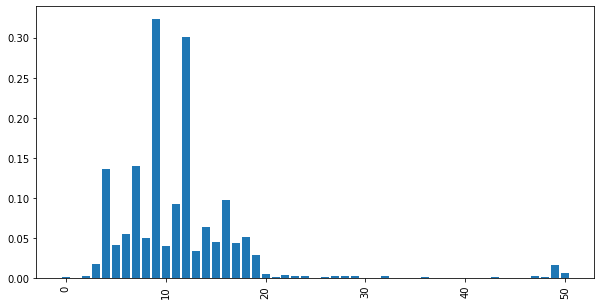

In [25]:
from matplotlib import pyplot as plt


# visualize which features were most important to the model
# this is a good way to see if there are any features that you can remove
# to improve your model
def visualize_features(model:sklearn.linear_model.LogisticRegression, feature_names:list):
    # get the coefficients of the model
    coef = model.coef_[0]

    # get the absolute value of the coefficients
    abs_coef = np.abs(coef)

    # sort the coefficients from highest to lowest
    sorted_coef = np.sort(abs_coef)[::-1]
    print("sorted_coef len: ", len(sorted_coef))

    # get the indexes of the coefficients from highest to lowest
    sorted_coef_index = np.argsort(abs_coef)[::-1]

    # match the coefficients to their feature names, and sort them from highest to lowest
    sorted_coef_names = []
    for i in sorted_coef_index:
        sorted_coef_names.append(feature_names[i])

    # create a figure
    fig = plt.figure(figsize=(10, 5))

    # plot the features and their coefficients
    plt.bar(sorted_coef_names, sorted_coef)

    # rotate the ticks on the x-axis
    plt.xticks(rotation=90)

    # show the plot
    plt.show()


visualize_features(model, list(np.arange(0, 51)))

In [29]:
class LogisticRegressor:
    def __init__(self, input_dim: int, num_classes: int):
        self.weights = torch.randn(input_dim, num_classes, requires_grad=True)
        self.bias = torch.randn(num_classes, requires_grad=True)

    def forward(self, feats: torch.Tensor) -> torch.Tensor:
        return torch.mm(feats, self.weights) + self.bias

    def backward(self, feats: torch.Tensor, output_scores: torch.Tensor, labels: torch.Tensor):
        loss = torch.nn.functional.cross_entropy(output_scores, labels)
        loss.backward()

        with torch.no_grad():
            self.weights -= 0.01 * self.weights.grad
            self.bias -= 0.01 * self.bias.grad

            # zero the gradients after updating
            self.weights.grad.zero_()
            self.bias.grad.zero_()

    def extract_feats(self, wavs: torch.Tensor):
        # insert your feature extraction logic here
        pass


In [30]:
from sklearn.model_selection import train_test_split
import torch

def train_and_test_model(features: np.ndarray, labels: np.ndarray, epochs: int=100):
    # convert features and labels to torch tensors
    features = torch.tensor(features, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)

    # split the features and labels into a training set and a testing set
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # get the number of features from the feature data
    input_dim = X_train.shape[1]

    # get the number of unique classes from the labels
    num_classes = len(torch.unique(labels))

    # create the model
    model = LogisticRegressor(input_dim, num_classes)

    # training loop
    for epoch in range(epochs):
        # forward pass
        output_scores = model.forward(X_train)

        # backward pass and optimization
        model.backward(X_train, output_scores, y_train)

        # print loss every 10 epochs
        if (epoch+1) % 10 == 0:
            loss = torch.nn.functional.cross_entropy(output_scores, y_train)
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

    # testing the model
    test_output_scores = model.forward(X_test)
    _, predicted = torch.max(test_output_scores.data, 1)
    correct = (predicted == y_test).sum().item()
    test_accuracy = correct / len(y_test)
    print(f'Test accuracy: {test_accuracy * 100:.2f}%')

    return model


In [31]:
model = train_and_test_model(features, labels, epochs=100)

C:\Users\PC\AppData\Local\Temp\ipykernel_10300\3220998991.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float32)
C:\Users\PC\AppData\Local\Temp\ipykernel_10300\3220998991.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 10/100, Loss: 30840.791015625
Epoch 20/100, Loss: 54237.51953125
Epoch 30/100, Loss: 33636.95703125
Epoch 40/100, Loss: 31511.73828125
Epoch 50/100, Loss: 2131.889404296875
Epoch 60/100, Loss: 4846.70458984375
Epoch 70/100, Loss: 6245.89453125
Epoch 80/100, Loss: 3658.55029296875
Epoch 90/100, Loss: 4493.28759765625
Epoch 100/100, Loss: 1713.122802734375
Test accuracy: 90.28%
